# Extended Forecasting Tutorial

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [2]:
np.random.seed(0)

## Datasets

The first requirement to use GluonTS is to have an appropriate dataset. GluonTS offers three different options to practitioners that want to experiment with the various modules: 

- Use an available dataset provided by GluonTS
- Create an artificial dataset using GluonTS
- Convert your dataset to a GluonTS friendly format

In general, a dataset should satisfy some minimum format requirements to be compatible with GluonTS. In particular, it should be an iterable collection of data entries (time series), and each entry should have at least a `target` field, which contains the actual values of the time series, and a `start` field, which denotes the starting date of the time series. There are many more optional fields that we will go through in this tutorial.

The datasets provided by GluonTS come in the appropriate format and they can be used without any post processing. However, a custom dataset needs to be converted. Fortunately this is an easy task.

### Available datasets in GluonTS

GluonTS comes with a number of available datasets.

In [3]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

c:\Users\cesar\anaconda3\envs\torchts\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

To download one of the built-in datasets, simply call `get_dataset` with one of the above names. GluonTS can re-use the saved dataset so that it does not need to be downloaded again the next time around.

In [8]:
dataset = get_dataset("m4_hourly")

### What is in a dataset?

In general, the datasets provided by GluonTS are objects that consists of three main members:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

First, let's see what the first entry of the train dataset contains. We should expect at least a `target` and a `start` field in each entry, and the target of the test entry to have an additional window equal to `prediction_length`.

In [9]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
train_entry.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'item_id'])

In [10]:
train_entry["target"].shape

(700,)

In [11]:
train_entry["start"]

Period('1750-01-01 00:00', 'H')

We observe that apart from the required fields there is one more `feat_static_cat` field (we can safely ignore the `source` field). This shows that the dataset has some features apart from the values of the time series. For now, we will ignore this field too. We will explain it in detail later with all the other optional fields.

We can similarly examine the first entry of the test dataset. We should expect exactly the same fields as in the train dataset.

In [12]:
# get the first time series in the test set
test_entry = next(iter(dataset.test))
test_entry.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'item_id'])

Moreover, we should expect that the target will have an additional window in the end with length equal to `prediction_length`. To better understand what this means we can visualize both the train and test time series.

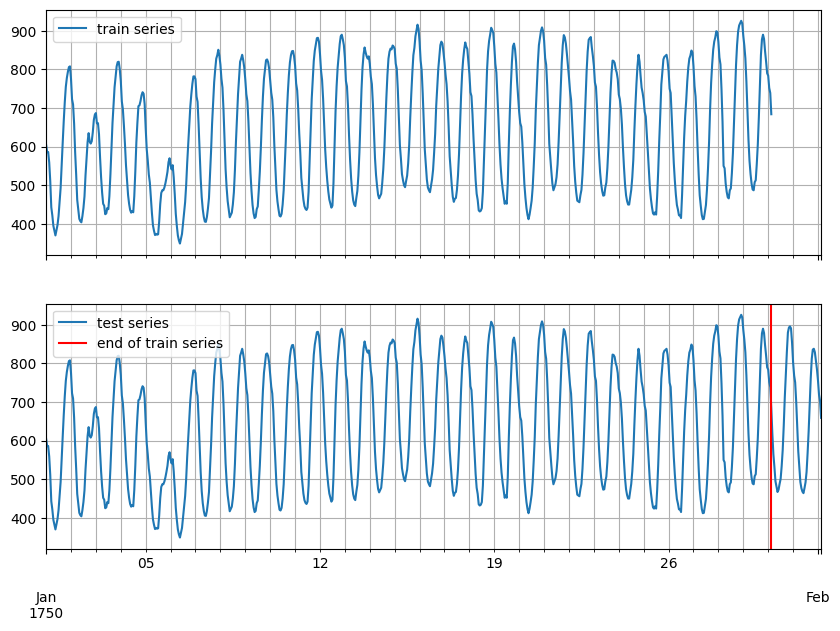

In [13]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [14]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Create artificial datasets

We can easily create a complex artificial time series dataset using the `ComplexSeasonalTimeSeries` module.

In [15]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [16]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

We can access some important metadata of the artificial dataset as follows:

In [17]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


The artificial dataset that we created is a list of dictionaries. Each dictionary corresponds to a time series and it should contain the required fields.

In [18]:
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


In order to use the artificially created datasets (list of dictionaries) we need to convert them to `ListDataset` objects.

In [19]:
train_ds = ListDataset(artificial_dataset.train, freq=artificial_dataset.metadata.freq)

In [20]:
test_ds = ListDataset(artificial_dataset.test, freq=artificial_dataset.metadata.freq)

In [21]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id'])

In [22]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id'])

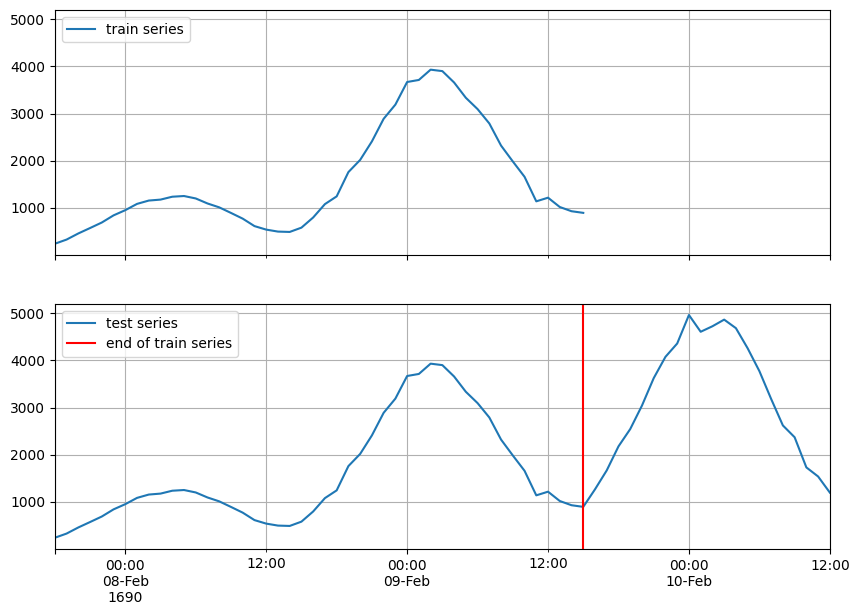

In [23]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

### Use your time series and features

Now, we will see how we can convert any custom dataset with any associated features to an appropriate format for GluonTS.

As already mentioned a dataset is required to have at least the `target` and the `start` fields. However, it may have more. Let's see what are all the available fields:

In [24]:
from gluonts.dataset.field_names import FieldName

In [25]:
[
    f"FieldName.{k} = '{v}'"
    for k, v in FieldName.__dict__.items()
    if not k.startswith("_")
]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.INFO = 'info'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_CAT = 'past_feat_dynamic_cat'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

The fields are split into three categories: the required ones, the optional ones, and the ones that can be added by the `Transformation` (explained in a while).

Required:

- `start`: start date of the time series
- `target`: values of the time series

Optional:

- `feat_static_cat`: static (over time) categorical features, list with dimension equal to the number of features
- `feat_static_real`: static (over time) real features, list with dimension equal to the number of features
- `feat_dynamic_cat`: dynamic (over time) categorical features, array with shape equal to (number of features, target length)
- `feat_dynamic_real`: dynamic (over time) real features, array with shape equal to (number of features, target length)

Added by `Transformation`:

- `time_feat`: time related features such as the month or the day 
- `feat_dynamic_const`: expands a constant value feature along the time axis
- `feat_dynamic_age`: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
- `observed_values`: indicator for observed values, i.e., a feature that equals to 1 if the value is observed and 0 if the value is missing
- `is_pad`: indicator for each time step that shows if it is padded (if the length is not enough) 
- `forecast_start`: forecast start date

As a simple example, we can create a custom dataset to see how we can use some of these fields. The dataset consists of a target, a real dynamic feature (which in this example we set to be the target value one period earlier), and a static categorical feature that indicates the sinusoid type (different phase) that we used to create the target.

In [26]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(
        np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period))
    )
    sin_Zero_2Pi = np.sin(
        np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period))
    )

    pattern = np.concatenate(
        (
            np.tile(sin_minusPi_Pi.reshape(1, -1), (int(np.ceil(num_series / 2)), 1)),
            np.tile(sin_Zero_2Pi.reshape(1, -1), (int(np.floor(num_series / 2)), 1)),
        ),
        axis=0,
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (np.zeros((num_series, period)), target[:, :-period]), axis=1
    )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2))),
        ),
        axis=0,
    )

    return target, feat_dynamic_real, feat_static_cat

In [27]:
# define the parameters of the dataset
custom_ds_metadata = {
    "num_series": 100,
    "num_steps": 24 * 7,
    "prediction_length": 24,
    "freq": "1H",
    "start": [pd.Period("01-01-2019", freq="1H") for _ in range(100)],
}

In [28]:
data_out = create_dataset(
    custom_ds_metadata["num_series"],
    custom_ds_metadata["num_steps"],
    custom_ds_metadata["prediction_length"],
)

target, feat_dynamic_real, feat_static_cat = data_out

We can easily create the train and test datasets by simply filling in the correct fields. Remember that for the train dataset we need to cut the last window.

In [29]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [30]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target, custom_ds_metadata["start"], feat_dynamic_real, feat_static_cat
        )
    ],
    freq=custom_ds_metadata["freq"],
)

Now, we can examine each entry of the train and test datasets. We should expect that they have the following fields: `target`, `start`, `feat_dynamic_real` and `feat_static_cat`.

In [31]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

In [32]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat'])

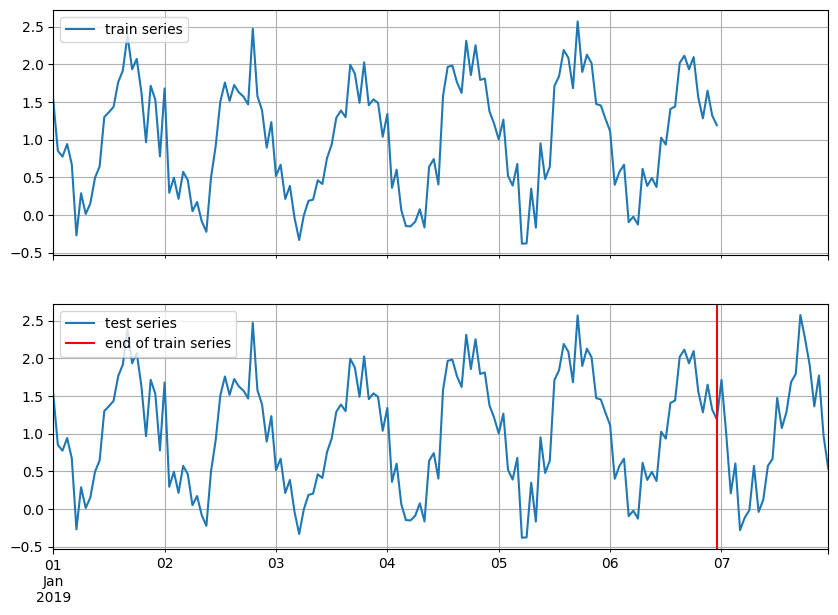

In [33]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

<span style="color:red">*For the rest of the tutorial we will use the custom dataset*</span>

## Transformations

### Define a transformation

The primary use case for a `Transformation` is for feature processing, e.g., adding a holiday feature and for defining the way the dataset will be split into appropriate windows during training and inference. 

In general, it gets an iterable collection of entries of a dataset and transform it to another iterable collection that can possibly contain more fields. The transformation is done by defining a set of "actions" to the raw dataset depending on what is useful to our model. This actions usually create some additional features or transform an existing feature. As an example, in the following we add the following transformations:

- `AddObservedValuesIndicator`: Creates the `observed_values` field in the dataset, i.e., adds a feature that equals to 1 if the value is observed and 0 if the value is missing 
- `AddAgeFeature`: Creates the `feat_dynamic_age` field in the dataset, i.e., adds a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp   

One more transformation that can be used is the `InstanceSplitter`, which is used to define how the datasets are going to be split in example windows during training, validation, or at prediction time. The `InstanceSplitter` is configured as follows (skipping the obvious fields):

- `is_pad_field`: indicator if the time series is padded (if the length is not enough)
- `train_sampler`: defines how the training windows are cut/sampled
- `time_series_fields`: contains the time dependent features that need to be split in the same manner as the target

In [34]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [35]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

### Transform a dataset

Now, we can create a transformation object by applying the above transformation to the custom dataset we have created.

In [36]:
transformation = create_transformation(
    custom_ds_metadata["freq"],
    2 * custom_ds_metadata["prediction_length"],  # can be any appropriate value
    custom_ds_metadata["prediction_length"],
)

In [37]:
train_tf = transformation(iter(train_ds), is_train=True)

In [38]:
type(train_tf)

generator

As expected, the output is another iterable object. We can easily examine what is contained in an entry of the transformed dataset. The `InstanceSplitter` iterates over the transformed dataset and cuts windows by selecting randomly a time series and a starting point on that time series (this "randomness" is defined by the `instance_sampler`).

In [39]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

The transformer has done what we asked. In particular it has added:

- a field for observed values (`observed_values`)  
- a field for the age feature (`feat_dynamic_age`)
- some extra useful fields (`past_is_pad`, `forecast_start`)

It has done one more important thing: it has split the window into past and future and has added the corresponding prefixes to all time dependent fields. This way we can easily use e.g., the `past_target` field as input and the `future_target` field to calculate the error of our predictions. Of course, the length of the past is equal to the `context_length` and of the future equal to the `prediction_length`.

In [40]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry["feat_static_cat"])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


Just for comparison, let's see again what were the fields in the original dataset before the transformation:

In [41]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat']

Now, we can move on and see how the test dataset is split. As we saw, the transformation splits the windows into past and future. However, during inference (`is_train=False` in the transformation), the splitter always cuts the last window (of length `context_length`) of the dataset so it can be used to predict the subsequent unknown values of length `prediction_length`. 

So, how is the test dataset split in past and future since we do not know the future target? And what about the time dependent features?

In [42]:
test_tf = transformation(iter(test_ds), is_train=False)

In [43]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [44]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry["feat_static_cat"])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


The future target is empty but not the features - we always assume that we know the future features!

All the things we did manually here are done by an internal block called `DataLoader`. It gets as an input the raw dataset (in appropriate format) and the transformation object and it outputs the transformed iterable dataset batch by batch. The only thing that we need to worry about is setting the transformation fields correctly!